# Photometry of Sources in a Spitzer field 

This Nb explains how to measure the photometry of an image (including background subtraction) of 3 sources ina an image. 
In the firs case, we select the 3 brightest sources in the images based on the 3 brightest pixels. In the second case, we use an external catalog and select the three brightest sources in that catalog. 

Note that the solution to that exercise also includes management of some conflicts that appears (at the time of writing this notebook) between the definition of SkyApertures based on an astropy table. Photutils requires the input table to be a plain numpy array not a masked array but the data we manipulate are in Masked Column. A solution to that problem consists in converting the original masked array into a plain numpy array as shown below 

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 2.3.:** Measure the flux for the 3 brightest point sources in the Spitzer image, after subtracting the estimated background level in a surrounding annulus. Consider appropriate values for the respective radii of the aperture and annulus. Beware of the presence of NaN values.

</div>

In [35]:
from photutils.aperture import CircularAperture, aperture_photometry, CircularAnnulus,  ApertureStats, SkyCircularAperture,  SkyCircularAnnulus
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
import astropy.units as u
from astropy.wcs import WCS
from photutils.datasets import load_spitzer_catalog, load_spitzer_image
import numpy as np 

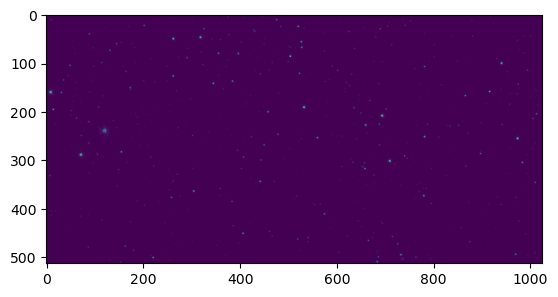

In [9]:
%matplotlib inline

spitzer_hdu = load_spitzer_image()
spitzer_image = spitzer_hdu.data
data = u.Quantity(spitzer_image, unit=spitzer_hdu.header['BUNIT'])  
wcs = WCS(spitzer_hdu.header)
catalog = load_spitzer_catalog()  
# start by showing again the Spitzer image:
plt.imshow(spitzer_image)

In [10]:
catalog

l,b,f4_5,df4_5,mag3_6,mag4_5,mag5_8,mag8_0,dist,angle,color36_45,color36_58,color36_80,color45_58,color45_80,color58_80
deg,deg,mJy,mJy,mag,mag,mag,mag,arcsec,deg,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
18.384317,0.240381,186.399994,8.521,7.307,7.461,7.162,7.131,1631.875011,76.381456,-0.154,0.145,0.176,0.299,0.33,0.031
18.38085,0.205,50.439999,2.436,8.746,8.879,8.768,8.761,1557.029253,75.96296,-0.133,-0.022,-0.015,0.111,0.118,0.007
18.383131,0.264819,59.169998,3.492,8.6,8.706,8.46,8.471,1676.691587,76.10213,-0.106,0.14,0.129,0.246,0.235,-0.011
18.380336,0.264739,53.349998,2.641,8.847,8.818,8.521,7.937,1668.259423,75.866811,0.029,0.326,0.91,0.297,0.881,0.584
18.343074,0.298394,53.959999,2.073,8.649,8.806,8.568,8.534,1636.920136,76.055416,-0.157,0.081,0.115,0.238,0.272,0.034
18.357916,0.289592,143.800003,6.073,7.543,7.742,7.366,7.273,1657.474097,76.156446,-0.199,0.177,0.27,0.376,0.469,0.093
18.335555,0.299889,149.699997,6.852,7.574,7.698,7.419,7.334,1620.179307,76.126882,-0.124,0.155,0.24,0.279,0.364,0.085
18.331838,0.168944,155.800003,6.852,7.46,7.655,7.287,7.315,1340.483811,76.235425,-0.195,0.173,0.145,0.368,0.34,-0.028


**First approach**: find coordinates of 3 max pixels. Since there are NaN values, let's proceed carefully:

In [11]:
# get the flattened indices that sort the array
ind_sort = spitzer_image.argsort(axis=None)[::-1]   # trick: [::-1] takes the array in reversed order, to have decreasing values. 
ind_sort

array([110266, 300041, 300040, ..., 441565,   6386, 442590],
      shape=(525825,))

In [13]:
# Now let's consider the first 3 values that are not NaN.
nmax = 3
ind_max = []
count_nan = 0

for ind in ind_sort:
    if np.isnan(spitzer_image.flatten()[ind]):  # alternative check: if spitzer_image.flatten()[ind] == spitzer_image.flatten()[ind]:
        count_nan += 1
    else:
        ind_max.append(ind)
        if len(ind_max)==nmax:
            break

print(f"There are {count_nan} NaN values")

There are 3 NaN values


In [14]:
# check
spitzer_image.flatten()[ind_max]

array([3938.2493, 3658.5698, 3635.2058], dtype='>f4')

In [15]:
# convert to (y,x) indices
ind_max_unrav = np.unravel_index(ind_max, spitzer_image.shape)
ind_max_unrav

(array([209, 364, 318]), array([693, 305, 659]))

In [16]:
# define list of (x,y) positions 
positions = [(ind_max_unrav[1][i], ind_max_unrav[0][i]) for i in range(nmax)]
positions

[(np.int64(693), np.int64(209)),
 (np.int64(305), np.int64(364)),
 (np.int64(659), np.int64(318))]

In [17]:
from photutils.aperture import CircularAnnulus, CircularAperture

apertures = CircularAperture(positions, r=5)
annulus_apertures = CircularAnnulus(positions, r_in=10, r_out=15)

In [19]:
i = 0
max(0,positions[i][0]-50), min(positions[i][0]+50, spitzer_image.shape[1])
#max(0,positions[i][1]-50), min(positions[i][1]+50, spitzer_image.shape[0])

(np.int64(643), np.int64(743))

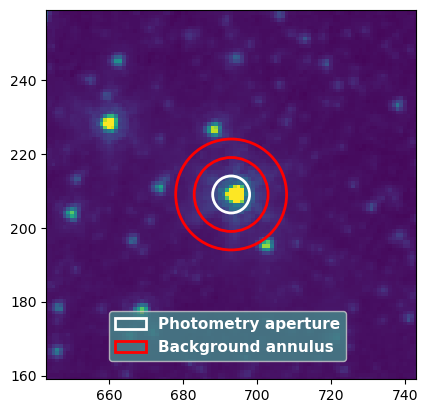

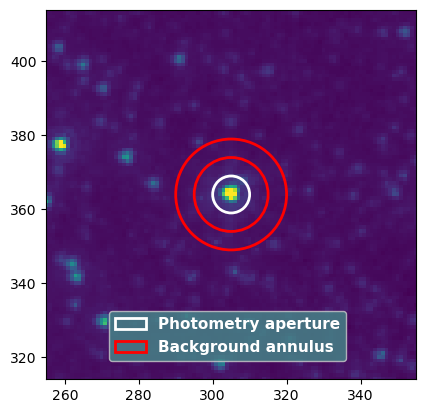

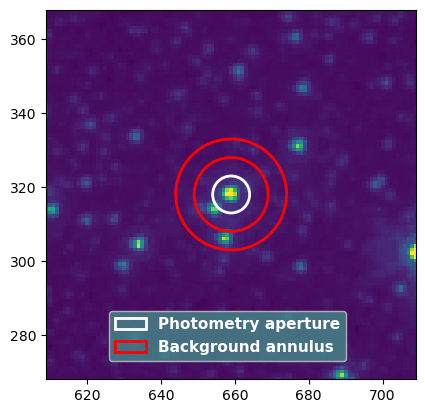

In [20]:
# plot
for i in range(nmax):
    norm = simple_norm(spitzer_image, 'sqrt', percent=99.9)
    plt.imshow(spitzer_image, norm=norm, interpolation='nearest')
    plt.xlim(max(0,positions[i][0]-50), min(positions[i][0]+50, spitzer_image.shape[1]))
    plt.ylim(max(0,positions[i][1]-50), min(positions[i][1]+50, spitzer_image.shape[0]))
    
    ap_patches = apertures.plot(color='white', lw=2,
                               label='Photometry aperture')
    ann_patches = annulus_apertures.plot(color='red', lw=2,
                                        label='Background annulus')
    handles = (ap_patches[i], ann_patches[i])
    plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
               handles=handles, prop={'weight': 'bold', 'size': 11})
    plt.show()

We see that the apertures are suboptimal. Let's redefine them. The first one is too small, the last is one is too large (overlap with a neighbouring star), and the annulus of the last one encompasses another star.

In [21]:
r = [12, 5, 4]
r_in=[25,10,15]
r_out=[30,15,20]

apertures = [CircularAperture(positions[i], r=r[i]) for i in range(nmax)]
annulus_apertures = [CircularAnnulus(positions[i], r_in=r_in[i], r_out=r_out[i]) for i in range(nmax)]

Let's check the new apertures:

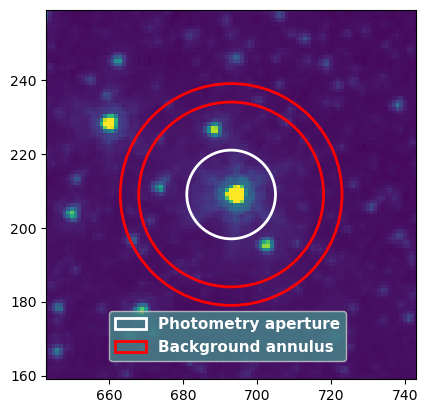

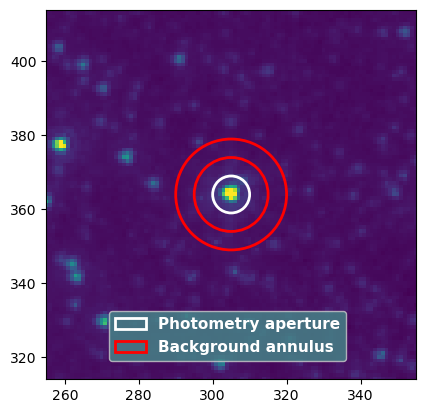

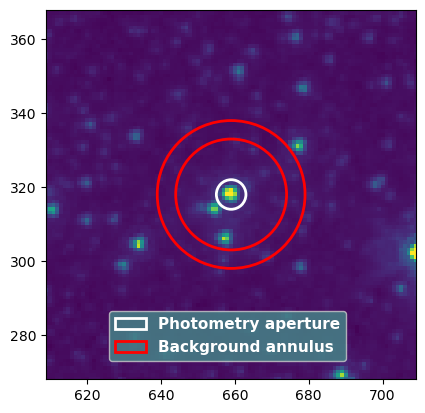

In [22]:
# plot
for i in range(nmax):
    norm = simple_norm(spitzer_image, 'sqrt', percent=99.9)
    plt.imshow(spitzer_image, norm=norm, interpolation='nearest')
    plt.xlim(max(0,positions[i][0]-50), min(positions[i][0]+50, spitzer_image.shape[1]))
    plt.ylim(max(0,positions[i][1]-50), min(positions[i][1]+50, spitzer_image.shape[0]))
    
    ap_patches = apertures[i].plot(color='white', lw=2,
                                   label='Photometry aperture')
    ann_patches = annulus_apertures[i].plot(color='red', lw=2,
                                            label='Background annulus')
    handles = (ap_patches[0], ann_patches[0])
    plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
               handles=handles, prop={'weight': 'bold', 'size': 11})
    plt.show()

Let's finally measure the photometry:

We can use the `ApertureStats` class to compute the **median** background level within the annulus aperture at each position (note we consider the median level instead of the mean level this time, due to the crowdness of the field, including in the annulus):

In [23]:
from photutils.aperture import ApertureStats
aperstats = [ApertureStats(spitzer_image, annulus_apertures[i]) for i in range(nmax)]
bkg_median = [aperstats[i].median for i in range(nmax)]
print(bkg_median)  

[np.float64(5.163347482681274), np.float64(4.869808912277222), np.float64(5.292374134063721)]


All values are indeed close to 5, which is good news.

In [24]:
phot_tables = [aperture_photometry(spitzer_image, apertures[i]) for i in range(nmax)]
total_bkg = [bkg_median[i] * apertures[i].area for i in range(nmax)] # scale bkg level by the area of each respective aperture 
phot_bkgsub = [phot_tables[i]['aperture_sum'] - total_bkg[i] for i in range(nmax)]  # subtract bkg level
phot_bkgsub

[<Column name='aperture_sum' dtype='float64' length=1>
 62413.60415607819,
 <Column name='aperture_sum' dtype='float64' length=1>
 22425.606988253607,
 <Column name='aperture_sum' dtype='float64' length=1>
 15503.070143584413]

Let's finally add the background estimates and background subtracted photometry to each table:

In [25]:
for i in range(nmax):
    phot_tables[i]['total_bkg'] = total_bkg[i]
    phot_tables[i]['aperture_sum_bkgsub'] = phot_bkgsub[i]
print(phot_tables)

[<QTable length=1>
  id  xcenter ycenter    aperture_sum        total_bkg      aperture_sum_bkgsub
int64 float64 float64      float64            float64             float64      
----- ------- ------- ------------------ ------------------ -------------------
    1   693.0   209.0 64749.447526889475 2335.8433708112893   62413.60415607819, <QTable length=1>
  id  xcenter ycenter    aperture_sum       total_bkg      aperture_sum_bkgsub
int64 float64 float64      float64           float64             float64      
----- ------- ------- ----------------- ------------------ -------------------
    1   305.0   364.0 22808.08088583351 382.47389757990555  22425.606988253607, <QTable length=1>
  id  xcenter ycenter    aperture_sum        total_bkg      aperture_sum_bkgsub
int64 float64 float64      float64            float64             float64      
----- ------- ------- ------------------ ------------------ -------------------
    1   659.0   318.0 15769.093882778385 266.02373919397166  15503.

**Second approach**: Use the Sky coordinates in the database and the known 3 brightest sources at 4.5 µm.

In [26]:
catalog

l,b,f4_5,df4_5,mag3_6,mag4_5,mag5_8,mag8_0,dist,angle,color36_45,color36_58,color36_80,color45_58,color45_80,color58_80
deg,deg,mJy,mJy,mag,mag,mag,mag,arcsec,deg,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
18.384317,0.240381,186.399994,8.521,7.307,7.461,7.162,7.131,1631.875011,76.381456,-0.154,0.145,0.176,0.299,0.33,0.031
18.38085,0.205,50.439999,2.436,8.746,8.879,8.768,8.761,1557.029253,75.96296,-0.133,-0.022,-0.015,0.111,0.118,0.007
18.383131,0.264819,59.169998,3.492,8.6,8.706,8.46,8.471,1676.691587,76.10213,-0.106,0.14,0.129,0.246,0.235,-0.011
18.380336,0.264739,53.349998,2.641,8.847,8.818,8.521,7.937,1668.259423,75.866811,0.029,0.326,0.91,0.297,0.881,0.584
18.343074,0.298394,53.959999,2.073,8.649,8.806,8.568,8.534,1636.920136,76.055416,-0.157,0.081,0.115,0.238,0.272,0.034
18.357916,0.289592,143.800003,6.073,7.543,7.742,7.366,7.273,1657.474097,76.156446,-0.199,0.177,0.27,0.376,0.469,0.093
18.335555,0.299889,149.699997,6.852,7.574,7.698,7.419,7.334,1620.179307,76.126882,-0.124,0.155,0.24,0.279,0.364,0.085
18.331838,0.168944,155.800003,6.852,7.46,7.655,7.287,7.315,1340.483811,76.235425,-0.195,0.173,0.145,0.368,0.34,-0.028


In [27]:
nmax=3
catalog.add_index('mag4_5')                # as seen before, sort by adding the relevant index
brightest_3sources = catalog.iloc[:nmax]   # then it's just a matter of truncating up to 3
brightest_3sources

l,b,f4_5,df4_5,mag3_6,mag4_5,mag5_8,mag8_0,dist,angle,color36_45,color36_58,color36_80,color45_58,color45_80,color58_80
deg,deg,mJy,mJy,mag,mag,mag,mag,arcsec,deg,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
18.195224,0.266825,446.200012,17.209999,--,6.513,5.963,5.601,1190.366709,73.564954,--,--,--,0.55,0.912,0.362
18.212413,0.170219,419.399994,19.690001,--,6.58,6.138,6.033,979.966757,74.004355,--,--,--,0.442,0.547,0.105
18.236739,0.219422,416.100006,16.26,--,6.588,6.215,6.027,1162.101507,73.239432,--,--,--,0.373,0.561,0.188


In [28]:
from astropy.table import QTable
brightest_3sources = QTable(brightest_3sources)

In [29]:
# check it found the right ones
brightest_3sources['l']

<MaskedQuantity [18.195224, 18.212413, 18.236739] deg>

In [30]:
from astropy.coordinates import SkyCoord

sky_positions = SkyCoord(brightest_3sources['l'], brightest_3sources['b'], frame='galactic')
sky_positions

<SkyCoord (Galactic): (l, b) in deg
    [(18.195224, 0.266825), (18.212413, 0.170219), (18.236739, 0.219422)]>

In [31]:
# don't forget to calculate the WCS object associated with the image
wcs = WCS(spitzer_hdu.header)

In [32]:
positions = sky_positions.to_pixel(wcs) # convert to pixel aperture objects (for plot below)
positions

(array([574.82799414, 523.26099363, 450.2829929 ]),
 array([410.975008  , 121.15700511, 268.76600658]))

In [33]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-CAR' 'GLAT-CAR' 
CRVAL : 18.0 0.0 
CRPIX : 1161.5 -388.5 
CD1_1 CD1_2  : -0.00033333333 0.0 
CD2_1 CD2_2  : 0.0 0.00033333333 
NAXIS : 1025  513

In [36]:
sky_positions.to_pixel(wcs) # This uses conversion in pixels from astropy  

(array([574.82799414, 523.26099363, 450.2829929 ]),
 array([410.975008  , 121.15700511, 268.76600658]))

In [37]:
print(type(sky_positions.l.value), type(sky_positions.b.value))

<class 'astropy.utils.masked.core.MaskedNDArray'> <class 'astropy.utils.masked.core.MaskedNDArray'>


The fact that the sky positions are built based on a masked array will cause trouble because photutils does not know how to handle masked arrays. We will need to convert the masked array to a normal array before converting to pixel coordinates.

This problem with masked array is revealed by running the following command that uses conversion in pixels from photutils (because sky_apertures is a photutils object): 

``` python 
sky_apertures = SkyCircularAperture(sky_positions, r=5 * u.arcsec ) 
apertures = sky_apertures.to_pixel(wcs) # convert to pixel aperture objects (for plot below)

```



In [38]:
sky_apertures = SkyCircularAperture(sky_positions, r=5 * u.arcsec ) 
apertures = sky_apertures.to_pixel(wcs) # convert to pixel aperture objects (for plot below)

TypeError: WCS world_axis_object_components results in values which are not scalars or plain Numpy arrays (got <class 'astropy.utils.masked.core.MaskedNDArray'>)

In [40]:
# To deal with the above error message as explained two cells above
sky_positions_corrected = SkyCoord(np.asarray(sky_positions.l.value), np.asarray(sky_positions.b.value), unit=(u.deg, u.deg), frame='galactic')
print(type(sky_positions_corrected.l.value), type(sky_positions_corrected.b.value))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [41]:
sky_apertures = SkyCircularAperture(sky_positions_corrected, r=5 * u.arcsec ) 
apertures = sky_apertures.to_pixel(wcs) # convert to pixel aperture objects (for plot below)

In [42]:
sky_annuli = SkyCircularAnnulus(sky_positions_corrected, r_in=7 * u.arcsec, r_out=10 * u.arcsec) 
annuli = sky_annuli.to_pixel(wcs)

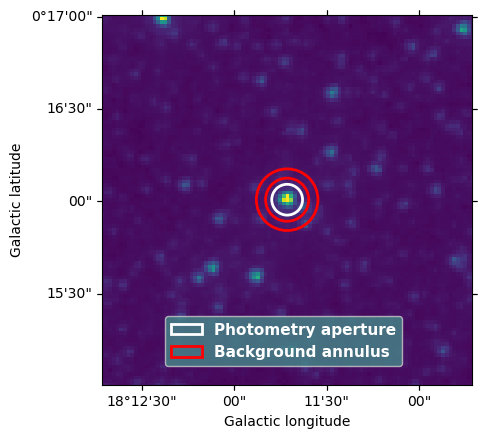

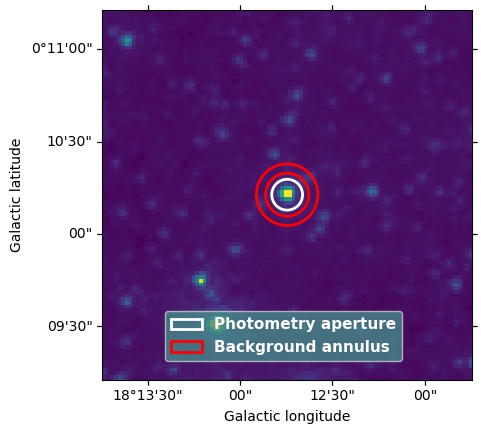

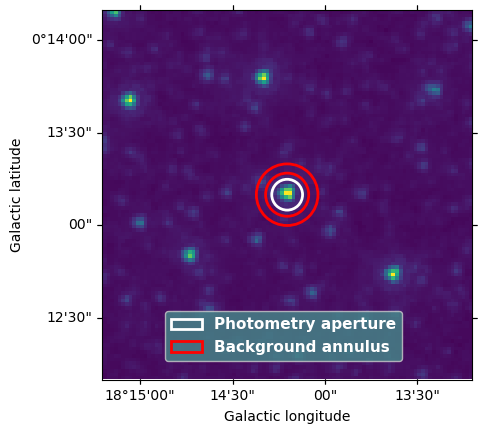

In [43]:
# plot
for i in range(nmax):
    ax = plt.subplot(projection=wcs)   # This initialises your axes transforming it to WCS 
    ax.imshow(spitzer_image, origin='lower')
    norm = simple_norm(spitzer_image, 'sqrt', percent=99.9)
    ax.imshow(spitzer_image, origin='lower', norm=norm, interpolation='nearest')
    ax.set_xlim(positions[0][i]-50, positions[0][i]+50)
    ax.set_ylim(positions[1][i]-50, positions[1][i]+50)
    #ax.grid(color='white', ls='solid')
    ax.set_xlabel('Galactic longitude')
    ax.set_ylabel('Galactic latitude')
    
    ap_patches = apertures.plot(color='white', lw=2,
                               label='Photometry aperture')
    ann_patches = annuli.plot(color='red', lw=2,
                                        label='Background annulus')
    handles = (ap_patches[i], ann_patches[i])
    plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
               handles=handles, prop={'weight': 'bold', 'size': 11})
    plt.show()

Upon inspection, let's make the apertures a bit bigger:

In [45]:
sky_apertures = SkyCircularAperture(sky_positions_corrected, r=7 * u.arcsec)
apertures = sky_apertures.to_pixel(wcs) # convert to pixel aperture objects (for plot below)
sky_annuli = SkyCircularAnnulus(sky_positions_corrected, r_in=12 * u.arcsec, r_out=20 * u.arcsec)
annuli = sky_annuli.to_pixel(wcs)

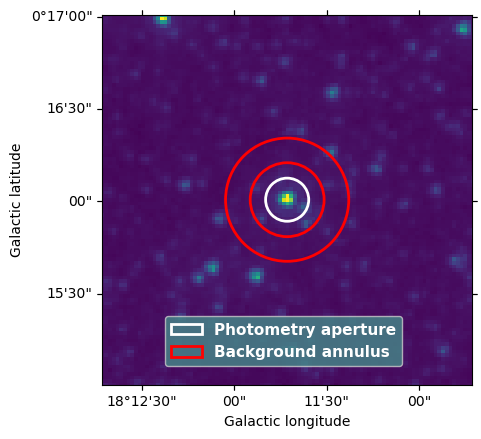

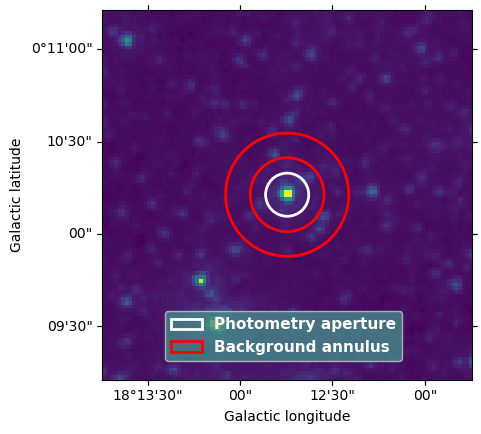

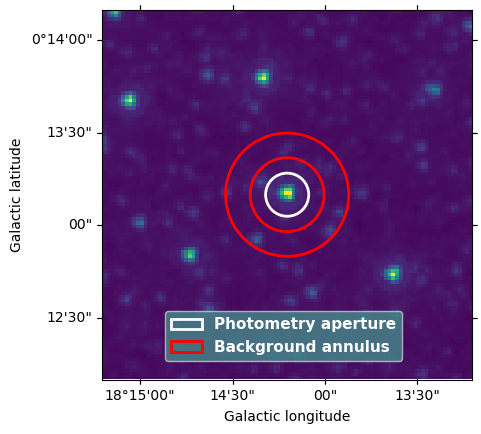

In [46]:
# plot
for i in range(nmax):
    ax = plt.subplot(projection=wcs)   # This initialises your axes transforming it to WCS 
    ax.imshow(spitzer_image, origin='lower')
    norm = simple_norm(spitzer_image, 'sqrt', percent=99.9)
    ax.imshow(spitzer_image, origin='lower', norm=norm, interpolation='nearest')
    ax.set_xlim(positions[0][i]-50, positions[0][i]+50)
    ax.set_ylim(positions[1][i]-50, positions[1][i]+50)
    #ax.grid(color='white', ls='solid')
    ax.set_xlabel('Galactic longitude')
    ax.set_ylabel('Galactic latitude')
    
    ap_patches = apertures.plot(color='white', lw=2,
                               label='Photometry aperture')
    ann_patches = annuli.plot(color='red', lw=2,
                                        label='Background annulus')
    handles = (ap_patches[i], ann_patches[i])
    plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
               handles=handles, prop={'weight': 'bold', 'size': 11})
    plt.show()

Note: these are different sources than the brightest individual pixels! This suggests that the brightest pixels do not correspond to sources listed in the catalogue.

Finally let's calculate the photometry:

We can use the `ApertureStats` class to compute the **median** background level within the annulus aperture at each position (note we consider the median level instead of the mean level this time, due to the crowdness of the field, including in the annulus):

In [47]:
from photutils.aperture import ApertureStats
aperstats = ApertureStats(spitzer_image, annuli)
bkg_median = aperstats.median
print(bkg_median)  

[4.51007938 4.76901197 4.39365482]


All values are indeed close to 5, which is good news.

In [48]:
phot_tables = aperture_photometry(spitzer_image, apertures)
total_bkg = bkg_median * apertures.area # scale bkg level by the area of each respective aperture 
phot_bkgsub = phot_tables['aperture_sum'] - total_bkg # subtract bkg level
phot_bkgsub

13612.429967347649
12704.367910905585
11580.43470538611


Let's finally add the background estimates and background subtracted photometry to each table:

In [49]:
phot_tables['total_bkg'] = total_bkg
phot_tables['aperture_sum_bkgsub'] = phot_bkgsub
print(phot_tables)

 id      xcenter      ...     total_bkg      aperture_sum_bkgsub
--- ----------------- ... ------------------ -------------------
  1  574.827994143281 ... 482.13388513644037  13612.429967347649
  2 523.2609936276053 ...  509.8141464386751  12704.367910905585
  3 450.2829928978298 ... 469.68793442817383   11580.43470538611


Note that compared to the first approach, we could get all the results in a single table as the apertures all have the same size now. Only if the apertures have the same size or are centered at the same location (with different radii) can the results be compiled in a single table.